In [1]:
import dmg.gallery as gallery
import dmg.dgmg as dgmg
import dmg.gmg_linear as gmg_linear
import dmg.classical_amg as classical_amg
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import xlsxwriter

In [2]:
n = 63
num_levels = 2
u_real = lambda x,y: np.sin(np.pi*3*x)*np.sin(np.pi*5*y)
rightf = lambda x,y:  34*np.pi**2*np.sin(3*np.pi*x)*np.sin(5*np.pi*y)
A = gallery.poisson((n, n))

解析解是$u_{real} = np.sin(np.pi*3*x)*np.sin(np.pi*5*y) $

右端项函数是$rightf = -34*np.pi**2*np.sin(3*np.pi*x)*np.sin(5*np.pi*y)$

解析解画出来是:
    ![](pic1.png)

## GMM

In [3]:
x0 = np.random.randn(A.shape)
x = np.linspace(0, 1, num=n+1, endpoint=False)
y = np.linspace(0, 1, num=n+1, endpoint=False)
xx, yy = np.meshgrid(x[1:], y[1:])
x_true = u_real(xx,yy)
rhs = rightf(xx,yy)/ (n+1)**2
rhs = rhs.reshape(A.shape, 1)

In [4]:
linear_gmg = gmg_linear.LinearGMG(A, max_levels=num_levels)
print(linear_gmg)
GMM_rho = linear_gmg.compute_rho()
print("Spectral radius = {}".format(GMM_rho))

Dimension of matrix A for levels:
Level = 0, dimension = (31, 31)
Level = 1, dimension = (63, 63)

Spectral radius = 0.1970554247753594


[7.37078926e+00 1.06221863e+00 1.74948220e-01 3.03360362e-02
 5.40917292e-03 9.81568719e-04 1.80289802e-04 3.34103103e-05
 6.23358609e-06 1.16927205e-06 2.20273593e-07 4.16432903e-08
 7.89606683e-09 1.50094475e-09 2.85925909e-10 5.45701442e-11]


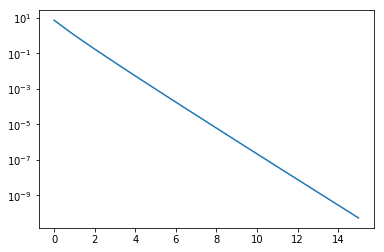

In [5]:
x = linear_gmg.solve(rhs, x0, tol=1e-10)
print(linear_gmg.get_gmg_convergence())
plt.semilogy(linear_gmg.get_gmg_convergence())

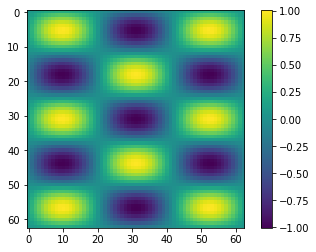

In [6]:
x = x.reshape(A.dim)
plt.imshow(x)
plt.colorbar()

## AMG

In [7]:
amg_solver = classical_amg.ClassicalAMG(A, num_levels)
AMG_rho = amg_solver.compute_rho()
print(amg_solver)
print("AMG spectral radius = {}".format(AMG_rho))

multilevel_solver
Number of Levels:     2
Operator Complexity:  1.886
Grid Complexity:      1.500
Coarse Solver:        'pinv2'
  level   unknowns     nonzeros
    0         3969        19593 [53.02%]
    1         1985        17361 [46.98%]

AMG spectral radius = 0.061728395061727906


[2.621613669039361, 2.524924809032183, 0.2805472010035751, 0.031171911222619763, 0.0034635456914016076, 0.0003848384101552393, 4.275982335061909e-05, 4.751091482823376e-06, 5.278990536672559e-07, 5.8655449872739576e-08, 6.517270686650515e-09, 7.241411000962815e-10, 8.045930711538577e-11]


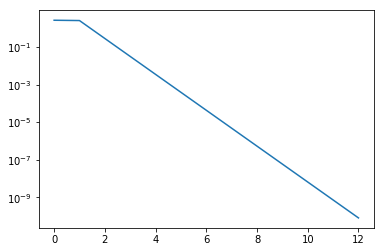

In [8]:
amg_solver = pyamg.classical.classical.ruge_stuben_solver(A.to_csr(), max_levels=num_levels, 
                                                                        max_coarse=1)
pyamg.relaxation.smoothing.change_smoothers(amg_solver,presmoother=("jacobi", {"omega": 2./3, "iterations": 2, "withrho": False}),postsmoother=("None"))
AMGres = []
x = amg_solver.solve(rhs, tol=1e-10,residuals=AMGres)
print(AMGres)
plt.semilogy(AMGres)

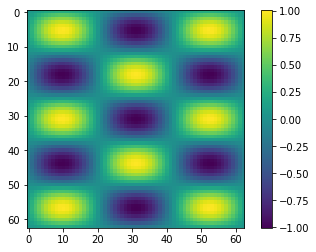

In [9]:
plt.imshow(x.reshape([n,n]))
plt.colorbar()

## DMM

In [10]:
x0 = np.random.randn(A.shape)
x = np.linspace(0, 1, num=n+1, endpoint=False)
y = np.linspace(0, 1, num=n+1, endpoint=False)
xx, yy = np.meshgrid(x[1:], y[1:])
rhs = rightf(xx,yy)/ (n+1)**2
rhs = rhs.reshape(A.shape, 1)

In [11]:
PR_stencil_type = "m9p"
gmm = dgmg.DeepMG(A, PR_stencil_type=PR_stencil_type, max_levels=num_levels)
num_iter = 2500
step_size = 1e-4
opt_par = gmm.optimize(num_iter=num_iter, step_size=step_size)

Iteration 100/2500
Upper bound estimation = 0.23306740899415967
Iteration 200/2500
Upper bound estimation = 0.22365224753594432
Iteration 300/2500
Upper bound estimation = 0.21258821117308244
Iteration 400/2500
Upper bound estimation = 0.20516646299524224
Iteration 500/2500
Upper bound estimation = 0.19575446253852805
Iteration 600/2500
Upper bound estimation = 0.18882915773478398
Iteration 700/2500
Upper bound estimation = 0.18383467576912846
Iteration 800/2500
Upper bound estimation = 0.17775030509842912
Iteration 900/2500
Upper bound estimation = 0.17176194447433035
Iteration 1000/2500
Upper bound estimation = 0.16616385838540015
Iteration 1100/2500
Upper bound estimation = 0.16042019015577821
Iteration 1200/2500
Upper bound estimation = 0.15719974614757645
Iteration 1300/2500
Upper bound estimation = 0.15268687136733755
Iteration 1400/2500
Upper bound estimation = 0.15175545769371157
Iteration 1500/2500
Upper bound estimation = 0.1528516840784582
Iteration 1600/2500
Upper bound est

In [12]:
print(gmm)
convergence = gmm.get_optimizer_convergence()
conv_time = gmm.get_optimization_time()
gmm.update_prd(opt_par)
DMM_rho = gmm.compute_rho()
print("DMM rho = {}".format(DMM_rho))

Dimension of matrix A for levels:
Level = 0, dimension = (31, 31)
Level = 1, dimension = (63, 63)

DMM rho = 0.12820450975299402


[1.04121790e+01 1.07083180e+00 1.18602898e-01 1.07315890e-02
 1.08789379e-03 1.17819601e-04 1.26702547e-05 1.42127145e-06
 1.62987061e-07 1.88730433e-08 2.20540612e-09 2.59437823e-10
 3.06917545e-11]


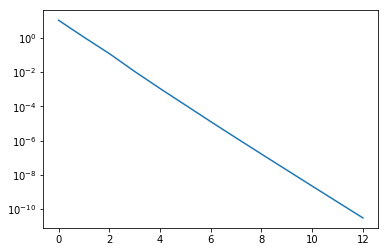

In [13]:
x = gmm.solve(rhs, x0, tol=1e-10)
print(gmm.get_gmg_convergence())
plt.semilogy(gmm.get_gmg_convergence())

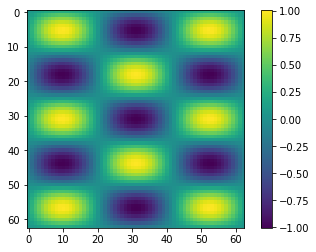

In [14]:
x = x.reshape(A.dim)
plt.imshow(x)
plt.colorbar()

## Compare

In [15]:
print("Radius of GMM={}".format(GMM_rho))
print("Radius of AMG={}".format(AMG_rho))
print("Radius of DMG={}".format(DMM_rho))

Radius of GMM=0.1970554247753594
Radius of AMG=0.061728395061727906
Radius of DMG=0.12820450975299402


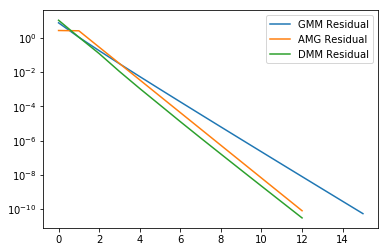

In [16]:
plt.semilogy(linear_gmg.get_gmg_convergence(), label = 'GMM Residual')
plt.semilogy(AMGres,label = "AMG Residual")
plt.semilogy(gmm.get_gmg_convergence(), label = 'DMM Residual')
plt.legend(loc='upper right')

In [17]:
print("GMM_rho : AMG_rho : DMM_rho = 1 : %f : %f" %(AMG_rho/GMM_rho,DMM_rho/GMM_rho))

GMM_rho : AMG_rho : DMM_rho = 1 : 0.313254 : 0.650601


## R, P and  $\omega$ after Optimization

The initial P, R in code is

P matrix:

[[0.25 0.5  0.25]

[0.5  1.   0.5 ]

[0.25 0.5  0.25]]

R matrix:

[[[0.0625 0.125  0.0625]

[0.125  0.25   0.125 ]

[0.0625 0.125  0.0625]]  

In [18]:
np.set_printoptions(threshold=np.inf)
print("omega = {}".format(opt_par[2]))

omega = 0.7974257186622089


In [19]:
P = opt_par[0][0]
k = int(2**(np.log2(n+1)-1)-1) 
P_Matrix = np.zeros([n**2,k**2])
for i in range(k):
    for j in range(k):
        C = P[i][j]
        for l in range(3):
            for m in range(3):
                P_Matrix[n*(2*i+l)+(2*j+m)][k*i+j] = C[l][m]
workbook = xlsxwriter.Workbook('P_Poisson.xlsx')
worksheet = workbook.add_worksheet()
for col, data in enumerate(P_Matrix):
    worksheet.write_column(0, col, data)
workbook.close()

In [20]:
R = opt_par[1][0]
R_Matrix = np.zeros([k**2,n**2])
for i in range(k):
    for j in range(k):
        C = R[i][j]
        for l in range(3):
            for m in range(3):
                R_Matrix[k*i+j][n*(2*i+l)+(2*j+m)] = C[l][m]
workbook = xlsxwriter.Workbook('R_Poisson.xlsx')
worksheet = workbook.add_worksheet()
for col, data in enumerate(R_Matrix):
    worksheet.write_column(0, col, data)
workbook.close()